# SDDP and newsvendor


In [1]:
using Distributions, JuMP, Gurobi, Plots, ProgressMeter
gurobi_env = Gurobi.Env()

Academic license - for non-commercial use only - expires 2021-03-16


Gurobi.Env(Ptr{Nothing} @0x0000000003b71ed0, false, 0)

In [33]:
p = 1.0 #day ahead price
q = 1.2 #same day price

#array de vectores de cuts. Arranca en la lower bound
cuts = [[0.0;0.0]];

#condicion inicial de stock
x0=0.0;

V(x) = q*(100 .-x).^2/(2*100)

V (generic function with 1 method)

## Stochastic Decomposition Alternative

In [34]:
#array de vectores de cuts. Arranca en la lower bound
cuts = [[0.0;0.0]];

#aca guardo los ruidos que fueron saliendo
noises = Array{Float64}(undef,0);
objective_values = Array{Float64}(undef,0);
explored_states = Array{Float64}(undef,0);
duals = Array{Float64}(undef,0);

#condicion inicial de stock
x0=0.0;

In [35]:
anim=Animation()

#@showprogress 1 "Computing..." for l=1:100
for l=1:200
    
    #resuelvo el primer paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

    @variable(model,reserve>=0);
    @variable(model,stock>=0);
    @variable(model,z);

    cut_constraints = [];
    for k=1:length(cuts)
        cut=cuts[k]
        c=@constraint(model,z>=cut[1]+cut[2]*(stock+reserve));
        push!(cut_constraints,c);
    end

    fix_x = @constraint(model,stock==x0);

    @objective(model,Min,p*reserve+z);

    optimize!(model)

    #purge cuts!
    #multipliers = [dual(c) for c in cut_constraints];
    #idx = filter(k->multipliers[k]!=0,(1:length(cuts)));
    #cuts = cuts[idx];

    #if l>40
    #    cuts = cuts[end-19:end]
    #end

    x=value(stock)+value(reserve);
    push!(explored_states,x)

    #resuelvo para un ruido en el segundo paso y agrego un corte
    demand=rand(DiscreteUniform(0,100));
    push!(noises,demand)


    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

    @variable(model,shortage>=0);
    @variable(model,stock_in>=0);

    @variable(model,stock_out>=0);

    @constraint(model,stock_in-demand+shortage==stock_out);

    fix_x = @constraint(model,x==stock_in);

    @objective(model,Min,q*shortage);

    optimize!(model)

    beta = objective_value(model);

    push!(objective_values,beta)

    #cambio el signo del multiplicador por que es >= en la constraint
    lambda = dual(fix_x)

    push!(duals,lambda)


    ##problema auxiliar para hallar el beta estimado de los cortes anteriores.
    aux = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

    @variable(aux, z2>=0)
    @variable(aux, x2>=0)

    cut_constraints = [];

    for k=1:length(cuts)
        cut=cuts[k]
        c=@constraint(aux,z2>=cut[1]+cut[2]*(x2));
        push!(cut_constraints,c);
    end
    @objective(aux,Min,z2)

    fix_x2 = @constraint(aux,x==x2)

    optimize!(aux)

    beta_est = objective_value(aux)
    lambda_est = dual.(fix_x2)
    println("Estado explorado: $x \t costo:$beta_est \t dual:$lambda_est")


    #update all previous cuts for averaging
    for j=1:length(cuts)
        cuts[j] = (l-1)/(l) * cuts[j];
    end

    new_cut = 1/(l)*[beta+lambda*x;-lambda]+(l-1)/(l)*[beta_est+lambda_est*x;-lambda_est]

    push!(cuts,new_cut);
    
    x=(0:100)
    pl=plot(;title="Iteracion $l",legend=:none,xlim=(0,100),ylim=(-10,100))
    plot!(pl,x,V.(x),lw=4)
    for i=1:length(cuts)-1
        cut=cuts[i]
        plot!(pl,cut[1].+cut[2]*x);
    end
    plot!(pl,cuts[end][1].+cuts[end][2]*x,lw=3);
    frame(anim)
    
end

Estado explorado: 0.0 	 costo:0.0 	 dual:0.0
Estado explorado: 66.0 	 costo:0.0 	 dual:0.0
Estado explorado: 0.0 	 costo:39.6 	 dual:0.6
Estado explorado: 0.0 	 costo:33.599999999999994 	 dual:0.7999999999999999
Estado explorado: 0.0 	 costo:29.699999999999996 	 dual:0.8999999999999999
Estado explorado: 0.0 	 costo:39.12 	 dual:0.96
Estado explorado: 21.999999999999996 	 costo:15.000000000000004 	 dual:0.8
Estado explorado: 0.0 	 costo:43.37142857142857 	 dual:0.8571428571428571
Estado explorado: 0.0 	 costo:51.74999999999999 	 dual:0.9
Estado explorado: 0.0 	 costo:53.73333333333333 	 dual:0.9333333333333332
Estado explorado: 0.0 	 costo:52.919999999999995 	 dual:0.96
Estado explorado: 0.0 	 costo:48.43636363636363 	 dual:0.9818181818181818
Estado explorado: 0.0 	 costo:50.69999999999999 	 dual:0.9999999999999999
Estado explorado: 45.749999999999986 	 costo:7.638461538461545 	 dual:0.6461538461538461
Estado explorado: 0.0 	 costo:50.22857142857142 	 dual:0.9428571428571428
Estado expl

Estado explorado: 0.0 	 costo:50.625000000000036 	 dual:0.9964285714285716
Estado explorado: 0.0 	 costo:50.814159292035434 	 dual:0.9982300884955753
Estado explorado: 49.447058823529446 	 costo:1.700309597523213 	 dual:0.10526315789473685
Estado explorado: 0.0 	 costo:50.70260869565221 	 dual:0.991304347826087
Estado explorado: 0.0 	 costo:51.082758620689695 	 dual:0.9931034482758622
Estado explorado: 0.0 	 costo:51.497435897435935 	 dual:0.994871794871795
Estado explorado: 0.0 	 costo:51.640677966101734 	 dual:0.9966101694915255
Estado explorado: 0.0 	 costo:51.43865546218491 	 dual:0.9983193277310924
Estado explorado: 30.00000000000021 	 costo:21.37999999999983 	 dual:0.9800000000000001
Estado explorado: 0.0 	 costo:50.955371900826485 	 dual:0.9917355371900827
Estado explorado: 0.0 	 costo:50.724590163934465 	 dual:0.9934426229508196
Estado explorado: 0.0 	 costo:50.67317073170735 	 dual:0.9951219512195121
Estado explorado: 0.0 	 costo:51.135483870967775 	 dual:0.9967741935483869
Es

### Animacion de los cortes

┌ Info: Saved animation to 
│   fn = /home/andres/workspace/julia/sddp/newsvendor/tmp4.gif
└ @ Plots /home/andres/.julia/packages/Plots/KN96c/src/animation.jl:104


Plots.AnimatedGif("/home/andres/workspace/julia/sddp/newsvendor/tmp4.gif")
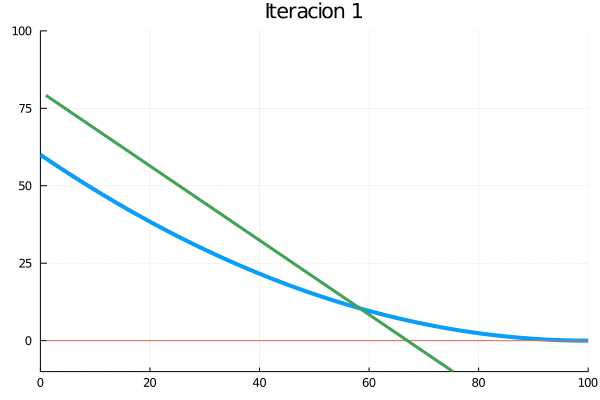

In [36]:
gif(anim,"tmp4.gif",fps=20)

### Resuelvo el problema de stock.

In [37]:
#resuelvo una vez mas para hallar el costo optimo
model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env)))

@variable(model,reserve>=0);
@variable(model,stock>=0);
@variable(model,z);

for i=1:length(cuts)
    cut=cuts[i]
    @constraint(model,z>=cut[1]+cut[2]*(stock+reserve));
end

fix_x = @constraint(model,stock==x0);

@objective(model,Min,p*reserve+z);

optimize!(model)

x=value(stock)+value(reserve);
costo = objective_value(model);

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 202 rows, 3 columns and 600 nonzeros
Model fingerprint: 0x15dbaf91
Coefficient statistics:
  Matrix range     [6e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 5e+01]
Presolve removed 36 rows and 1 columns
Presolve time: 0.00s
Presolved: 166 rows, 2 columns, 332 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.198890e+03   0.000000e+00      0s
       1    5.1828000e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds
Optimal objective  5.182800000e+01

User-callback calls 33, time in user-callback 0.00 sec


In [38]:
x

0.0

In [39]:
cuts

201-element Array{Array{Float64,1},1}:
 [0.0, 0.0]
 [0.3959999999999999, -0.006000000000000003]
 [0.0, -0.0]
 [0.5040000000000001, -0.012000000000000005]
 [0.5940000000000003, -0.017999999999999995]
 [0.9779999999999988, -0.02400000000000001]
 [1.1099999999999992, -0.030000000000000006]
 [1.5179999999999985, -0.030000000000000006]
 [2.0700000000000007, -0.03599999999999999]
 [2.4179999999999984, -0.041999999999999996]
 [2.645999999999999, -0.04800000000000002]
 [2.664, -0.05400000000000001]
 [3.042000000000005, -0.06000000000000001]
 ⋮
 [48.26999999999999, -0.9419999999999993]
 [48.79799999999998, -0.9479999999999993]
 [49.319999999999986, -0.9539999999999993]
 [49.79399999999999, -0.9599999999999992]
 [50.18399999999998, -0.9659999999999992]
 [45.63000000000001, -0.8639999999999995]
 [50.68799999999998, -0.9719999999999993]
 [50.72999999999998, -0.9779999999999992]
 [50.89199999999999, -0.9839999999999991]
 [51.28799999999998, -0.9899999999999992]
 [51.82799999999998, -0.9959999999999

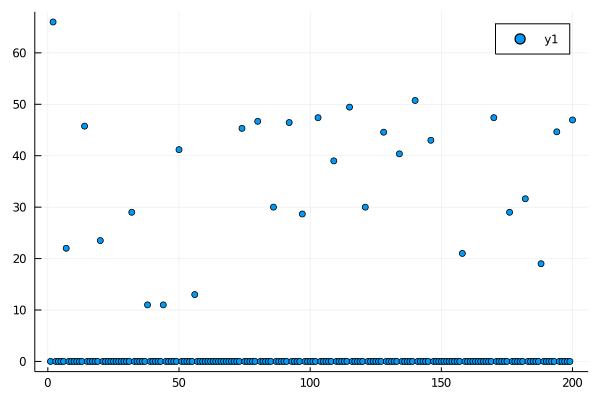

In [40]:
scatter(explored_states)